<a href="https://www.kaggle.com/code/ahmedmzaid/eyeofhourus-classification?scriptVersionId=175670187" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Imports

In [1]:
import cv2
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
%matplotlib inline

# Helper Function: Create DataFrame
- Takes a path to a folder (train/val) containing classes (sub-folders)
- Returns a DataFrame with 2 columns: filename, class

In [2]:
def create_dataframe(data_path):
    df = []
    for c in os.listdir(data_path):
        class_folder = os.path.join(data_path, c)
        for f in os.listdir(class_folder):
            f_path = os.path.join(class_folder, f)
            if f_path.endswith(('jpg' , 'png' , 'jpeg', 'bmp')):
                df.append([f_path, c])
    return pd.DataFrame(df, columns=('filename', 'class'))

# Creating DataFrames

In [3]:
# constants
IMG_DIM = 224
DATA_PATH = '/kaggle/input/cctv-gender-classifier-dataset/CCTV Gender Classifier Dataset'
CLASSES = sorted(['MALE', 'FEMALE'])
print(CLASSES)

['FEMALE', 'MALE']


In [4]:
# creating dataframes
df = create_dataframe(os.path.join(DATA_PATH))

# Splitting Data

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
df_train_val, df_test = train_test_split(df, test_size=0.30, random_state=0)

In [7]:
df_train, df_val = train_test_split(df_train_val, test_size=0.30, random_state=0)

In [8]:
df_train

,filename,class
18512,/kaggle/input/cctv-gender-classifier-dataset/C...,MALE
18261,/kaggle/input/cctv-gender-classifier-dataset/C...,MALE
15070,/kaggle/input/cctv-gender-classifier-dataset/C...,MALE
7680,/kaggle/input/cctv-gender-classifier-dataset/C...,FEMALE
4865,/kaggle/input/cctv-gender-classifier-dataset/C...,FEMALE
...,...,...
9144,/kaggle/input/cctv-gender-classifier-dataset/C...,FEMALE
15922,/kaggle/input/cctv-gender-classifier-dataset/C...,MALE
14820,/kaggle/input/cctv-gender-classifier-dataset/C...,MALE
8284,/kaggle/input/cctv-gender-classifier-dataset/C...,FEMALE


# Data generators (reading data from disk)

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2024-05-04 17:24:21.710845: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-04 17:24:21.710940: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-04 17:24:21.818791: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [10]:
def prefun(image):
    img = cv2.GaussianBlur(image, (5, 5), 0)
    return img

In [11]:
train_gen = ImageDataGenerator(preprocessing_function=prefun).flow_from_dataframe(
    df_train,
    target_size=(IMG_DIM, IMG_DIM),
    classes=CLASSES,
)

val_gen = ImageDataGenerator(preprocessing_function=prefun).flow_from_dataframe(
    df_val,
    target_size=(IMG_DIM, IMG_DIM),
    classes=CLASSES,
    shuffle=False,
)

test_gen = ImageDataGenerator(preprocessing_function=prefun).flow_from_dataframe(
    df_test,
    target_size=(IMG_DIM, IMG_DIM),
    classes=CLASSES,
    shuffle=False,
)

Found 9370 validated image filenames belonging to 2 classes.
Found 4016 validated image filenames belonging to 2 classes.
Found 5737 validated image filenames belonging to 2 classes.


In [12]:
train_gen.class_indices

{'FEMALE': 0, 'MALE': 1}

In [13]:
img = train_gen[0][0][0]

img.max()

255.0

# Models

### 1. Custom CNN

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, GlobalAvgPool2D, Dense, Flatten

model = Sequential()
model.add(Conv2D(16, 7, activation='relu', input_shape=(IMG_DIM, IMG_DIM, 3)))
model.add(Conv2D(16, 7, activation='relu'))
model.add(Conv2D(16, 7, activation='relu'))
model.add(MaxPool2D(2))
model.add(Conv2D(32, 5, activation='relu'))
model.add(Conv2D(32, 5, activation='relu'))
model.add(Conv2D(32, 5, activation='relu'))
model.add(MaxPool2D(2))
model.add(Conv2D(64, 3, activation='relu'))
model.add(Conv2D(64, 3, activation='relu'))
model.add(Conv2D(64, 3, activation='relu', name='last_conv'))
model.add(MaxPool2D(2))
model.add(Flatten())
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

MODEL_PATH = 'saved-models/cnn.weights.h5'

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 218, 218, 16)   │         2,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 212, 212, 16)   │        12,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 206, 206, 16)   │        12,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 103, 103, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 99, 99, 32)     │        12,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 95, 95, 32)     │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 91, 91, 32)     │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 43, 43, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 41, 41, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ last_conv (Conv2D)              │ (None, 39, 39, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 19, 19, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 23104)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │        46,210 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 230,146 (899.01 KB)

 Trainable params: 230,146 (899.01 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
#basic cnn
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(MODEL_PATH,
                            save_weights_only=True,
                            save_best_only=True,
                            verbose=1)
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=[checkpoint],
)

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  2/293 ━━━━━━━━━━━━━━━━━━━━ 24s 85ms/step - accuracy: 0.4922 - loss: 36.7200  

I0000 00:00:1714843516.168940      68 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


293/293 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.5383 - loss: 3.9555
Epoch 1: val_loss improved from inf to 0.65030, saving model to saved-models/cnn.weights.h5
293/293 ━━━━━━━━━━━━━━━━━━━━ 96s 238ms/step - accuracy: 0.5384 - loss: 3.9467 - val_accuracy: 0.6387 - val_loss: 0.6503
Epoch 2/10
293/293 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.6122 - loss: 0.6637
Epoch 2: val_loss improved from 0.65030 to 0.63172, saving model to saved-models/cnn.weights.h5
293/293 ━━━━━━━━━━━━━━━━━━━━ 31s 104ms/step - accuracy: 0.6122 - loss: 0.6637 - val_accuracy: 0.6531 - val_loss: 0.6317
Epoch 3/10
293/293 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.6392 - loss: 0.6446
Epoch 3: val_loss did not improve from 0.63172
293/293 ━━━━━━━━━━━━━━━━━━━━ 30s 102ms/step - accuracy: 0.6391 - loss: 0.6447 - val_accuracy: 0.6357 - val_loss: 0.6403
Epoch 4/10
293/293 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.6395 - loss: 0.6431
Epoch 4: val_loss improved from 0.63172 to 0.62042, saving model to

### 2. MobileNet

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.layers import GlobalAvgPool2D, Dense

In [17]:
pretrained = MobileNetV2(
    input_shape=(IMG_DIM, IMG_DIM, 3),
    include_top=False
)
pretrained.trainable = False

model = Sequential()
model.add(pretrained)
model.add(GlobalAvgPool2D())
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

MODEL_PATH = 'saved-models/mobilenet.weights.h5'

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ ?                      │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [18]:
pretrained.summary()

Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [19]:
#mobileNet
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(MODEL_PATH,
                            save_weights_only=True,
                            save_best_only=True,
                            verbose=1)
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=[checkpoint],
)

Epoch 1/10
292/293 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.6079 - loss: 0.6842
Epoch 1: val_loss improved from inf to 0.60059, saving model to saved-models/mobilenet.weights.h5
293/293 ━━━━━━━━━━━━━━━━━━━━ 46s 122ms/step - accuracy: 0.6081 - loss: 0.6839 - val_accuracy: 0.6721 - val_loss: 0.6006
Epoch 2/10
292/293 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.6618 - loss: 0.6170
Epoch 2: val_loss did not improve from 0.60059
293/293 ━━━━━━━━━━━━━━━━━━━━ 24s 80ms/step - accuracy: 0.6618 - loss: 0.6169 - val_accuracy: 0.6656 - val_loss: 0.6284
Epoch 3/10
292/293 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.6782 - loss: 0.5873
Epoch 3: val_loss improved from 0.60059 to 0.57674, saving model to saved-models/mobilenet.weights.h5
293/293 ━━━━━━━━━━━━━━━━━━━━ 24s 82ms/step - accuracy: 0.6783 - loss: 0.5873 - val_accuracy: 0.6815 - val_loss: 0.5767
Epoch 4/10
292/293 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.7003 - loss: 0.5633
Epoch 4: val_loss improved from 0.57674 to 0.57

### 3. ResNet

In [20]:
from tensorflow.keras.applications.resnet import ResNet152

In [21]:
pretrained = ResNet152(
    input_shape=(IMG_DIM, IMG_DIM, 3),
    include_top=False
)
pretrained.trainable = False

model = Sequential()
model.add(pretrained)
model.add(GlobalAvgPool2D())
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

MODEL_PATH = 'saved-models/resnet.weights.h5'

234698864/234698864 ━━━━━━━━━━━━━━━━━━━━ 10s 0us/step


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet152 (Functional)          │ ?                      │    58,370,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,370,944 (222.67 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 58,370,944 (222.67 MB)

In [22]:
pretrained.summary()

Model: "resnet152"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_3[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 58,370,944 (222.67 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 58,370,944 (222.67 MB)

In [23]:
#resnet
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(MODEL_PATH,
                            save_weights_only=True,
                            save_best_only=True,
                            verbose=1)
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=[checkpoint],
)

Epoch 1/10
  2/293 ━━━━━━━━━━━━━━━━━━━━ 34s 117ms/step - accuracy: 0.4922 - loss: 0.8709  

W0000 00:00:1714844179.567447      68 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


293/293 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.6738 - loss: 0.6387

W0000 00:00:1714844230.960640      68 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_loss improved from inf to 0.48975, saving model to saved-models/resnet.weights.h5
293/293 ━━━━━━━━━━━━━━━━━━━━ 100s 248ms/step - accuracy: 0.6740 - loss: 0.6385 - val_accuracy: 0.7517 - val_loss: 0.4897
Epoch 2/10
293/293 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.7683 - loss: 0.4855
Epoch 2: val_loss improved from 0.48975 to 0.47005, saving model to saved-models/resnet.weights.h5
293/293 ━━━━━━━━━━━━━━━━━━━━ 49s 165ms/step - accuracy: 0.7683 - loss: 0.4855 - val_accuracy: 0.7717 - val_loss: 0.4700
Epoch 3/10
293/293 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.7885 - loss: 0.4527
Epoch 3: val_loss did not improve from 0.47005
293/293 ━━━━━━━━━━━━━━━━━━━━ 47s 160ms/step - accuracy: 0.7885 - loss: 0.4527 - val_accuracy: 0.7724 - val_loss: 0.4774
Epoch 4/10
293/293 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.7975 - loss: 0.4235
Epoch 4: val_loss did not improve from 0.47005
293/293 ━━━━━━━━━━━━━━━━━━━━ 48s 161ms/step - accuracy: 0.7975 - loss: 0.4235 - val_ac

In [24]:
from tensorflow.keras.applications import ConvNeXtXLarge

In [25]:
pretrained = ConvNeXtXLarge(
    input_shape=(IMG_DIM, IMG_DIM, 3),
    include_top=False
)
pretrained.trainable = False

model = Sequential()
model.add(pretrained)
model.add(GlobalAvgPool2D())
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

MODEL_PATH = 'saved-models/convnext_xlarge.weights.h5'

1393257616/1393257616 ━━━━━━━━━━━━━━━━━━━━ 49s 0us/step


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ convnext_xlarge (Functional)    │ ?                      │   348,147,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 348,147,968 (1.30 GB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 348,147,968 (1.30 GB)

In [26]:
pretrained.summary()

Model: "convnext_xlarge"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_xlarge_pr… │ (None, 224, 224,  │          0 │ input_layer_5[0]… │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_xlarge_st… │ (None, 56, 56,    │     13,056 │ convnext_xlarge_… │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_xlarge_st… │ (None, 56, 56,    │     12,800 │ convnext_xlarge_… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_xlarge_st… │ (None, 56, 56,    │        512 │ convnext_xlarge_… │
│ (LayerNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_xlarge_st… │ (None, 56, 56,    │    263,168 │ convnext_xlarge_… │
│ (Dense)             │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_xlarge_st… │ (None, 56, 56,    │          0 │ convnext_xlarge_… │
│ (Activation)        │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_xlarge_st… │ (None, 56, 56,    │    262,400 │ convnext_xlarge_… │
│ (Dense)             │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_xlarge_st… │ (None, 56, 56,    │        256 │ convnext_xlarge_… │
│ (LayerScale)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_xlarge_st… │ (None, 56, 56,    │          0 │ convnext_xlarge_… │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 56, 56,    │          0 │ convnext_xlarge_… │
│                     │ 256)              │            │ convnext_xlarge_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_xlarge_st… │ (None, 56, 56,    │     12,800 │ add[0][0]         │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_xlarge_st… │ (None, 56, 56,    │        512 │ convnext_xlarge_… │
│ (LayerNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_xlarge_st… │ (None, 56, 56,    │    263,168 │ convnext_xlarge_… │
│ (Dense)             │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_xlarge_st… │ (None, 56, 56,    │          0 │ convnext_xlarge_… │
│ (Activation)        │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_xlarge_st… │ (None, 56, 56,    │    262,400 │ convnext_xlarge_… │
│ (Dense)             │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_xlarge_st… │ (None, 56, 56,    │        256 │ convnext_xlarge_

 Total params: 348,147,968 (1.30 GB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 348,147,968 (1.30 GB)

In [27]:
#ConvNeXtXLarge
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(MODEL_PATH,
                            save_weights_only=True,
                            save_best_only=True,
                            verbose=1)
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    callbacks=[checkpoint],
)

Epoch 1/50


W0000 00:00:1714844808.007894      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1714844808.008251      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1714844808.008746      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


261/293 ━━━━━━━━━━━━━━━━━━━━ 18s 579ms/step - accuracy: 0.7154 - loss: 0.5275

W0000 00:00:1714844968.326693      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1714844968.327120      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1714844968.327844      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


293/293 ━━━━━━━━━━━━━━━━━━━━ 0s 610ms/step - accuracy: 0.7219 - loss: 0.5194

W0000 00:00:1714844993.347243      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1714844993.347614      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1714844993.348035      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_loss improved from inf to 0.38933, saving model to saved-models/convnext_xlarge.weights.h5
293/293 ━━━━━━━━━━━━━━━━━━━━ 294s 909ms/step - accuracy: 0.7221 - loss: 0.5192 - val_accuracy: 0.8217 - val_loss: 0.3893
Epoch 2/50
293/293 ━━━━━━━━━━━━━━━━━━━━ 0s 579ms/step - accuracy: 0.8247 - loss: 0.3682
Epoch 2: val_loss did not improve from 0.38933
293/293 ━━━━━━━━━━━━━━━━━━━━ 243s 827ms/step - accuracy: 0.8247 - loss: 0.3682 - val_accuracy: 0.8182 - val_loss: 0.3948
Epoch 3/50
293/293 ━━━━━━━━━━━━━━━━━━━━ 0s 579ms/step - accuracy: 0.8418 - loss: 0.3509
Epoch 3: val_loss improved from 0.38933 to 0.36688, saving model to saved-models/convnext_xlarge.weights.h5
293/293 ━━━━━━━━━━━━━━━━━━━━ 246s 839ms/step - accuracy: 0.8418 - loss: 0.3508 - val_accuracy: 0.8352 - val_loss: 0.3669
Epoch 4/50
293/293 ━━━━━━━━━━━━━━━━━━━━ 0s 579ms/step - accuracy: 0.8538 - loss: 0.3274
Epoch 4: val_loss did not improve from 0.36688
293/293 ━━━━━━━━━━━━━━━━━━━━ 243s 828ms/step - accuracy: 0.8537 - 

# Loading best weights and Testing

In [28]:
print(MODEL_PATH)
model.load_weights(MODEL_PATH)
model.evaluate(test_gen)

saved-models/convnext_xlarge.weights.h5
180/180 ━━━━━━━━━━━━━━━━━━━━ 109s 607ms/step - accuracy: 0.8372 - loss: 0.3626


[0.3545134663581848, 0.8422520756721497]

# Analyzing model
### 1. Saliency maps

In [29]:
import tensorflow as tf

def saliency_map(img):
    
    plt.imshow(img/255.0)
    plt.show()

    x = tf.Variable(np.expand_dims(img, 0), dtype='float32')

    with tf.GradientTape() as tape:
        result = model(x)
        y = result[:, np.argmax(result)]
        grads = tape.gradient(y, x)

    grads_2d = grads.numpy()[0].max(axis=2)
    grads_2d_norm = (grads_2d - grads_2d.min())/(grads_2d.max() - grads_2d.min())

    grads_2d_uint8 = (grads_2d_norm*255.0).astype('uint8')
    _, grads_2d_bin = cv2.threshold(grads_2d_uint8, 0, 255, cv2.THRESH_OTSU)
    plt.imshow(grads_2d_bin, cmap='gray')
    plt.show()
    
    print(CLASSES[np.argmax(result)])

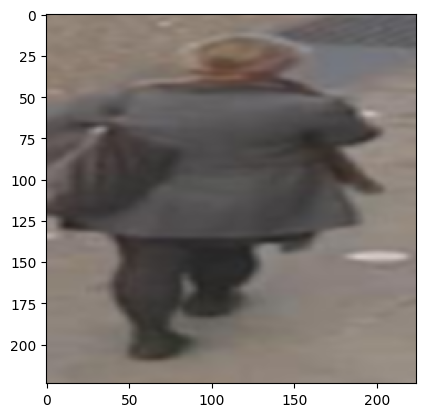

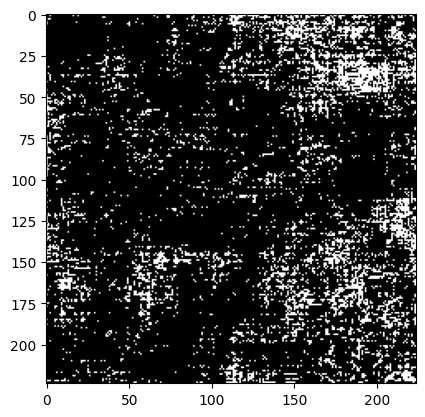

FEMALE


In [30]:
img = test_gen[0][0][1]
saliency_map(img)    

### 2. Gradient-weighted Class Activation Mapping (Grad-CAM)

In [31]:
def grad_cam_heatmap(image, last_conv_layer_name='last_conv'):
    
    if model.layers[0].__class__.__name__ == 'Functional':
        last_conv_layer_idx = 0
        last_conv_layer_model = model.layers[0]
    else:
        last_conv_layer = model.get_layer(last_conv_layer_name)
        last_conv_layer_idx = model.layers.index(last_conv_layer)
        last_conv_layer_model = tf.keras.Model(model.inputs, last_conv_layer.output)


    classifier_input = tf.keras.Input(shape=last_conv_layer_model.output.shape[1:])
    x = classifier_input
    classifier_layers = model.layers[last_conv_layer_idx+1:]
    for layer in classifier_layers:
        x = layer(x)
    classifier_model = tf.keras.Model(classifier_input, x)


    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(image)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]
        print(CLASSES[top_pred_index])

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)


    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)

    return heatmap

In [32]:
import matplotlib.cm as cm

def grad_cam(img, last_conv_layer_name='last_conv'):
    colors = cm.jet(np.arange(256))[:, :3]
    gc_mask = grad_cam_heatmap(np.expand_dims(img, 0), last_conv_layer_name)
    gc_mask_uint8 = (gc_mask*255.0).astype('uint8')
    heatmap = colors[gc_mask_uint8]
    heatmap = cv2.resize(heatmap, (IMG_DIM, IMG_DIM))
    heatmap = (heatmap*255).astype('uint8')
    img_uint8 = img.astype('uint8')
    img_overlay = cv2.addWeighted(src1=img_uint8, alpha=0.6, src2=heatmap, beta=0.4, gamma=0.0)
    plt.imshow(img_overlay)
    plt.show()

MALE


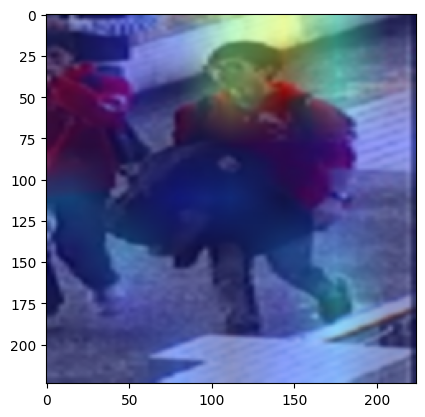

In [33]:
img = test_gen[20][0][4]
grad_cam(img)